# Moving Box | 64x64 | - Encoder Decoder - Train

In [1]:
import sys
sys.path.append('..')
from util import *
from util.parser import *
from util.saver import *
from util.img_kit import *
from util.notebook_display import *
from util.numeric_ops import *
from util.tf_ops import *

from IPython import display
import numpy as np
from scipy import ndimage
from scipy import misc
from os import walk
import os
import tensorflow as tf
from PIL import Image
from time import time

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['figure.figsize'] = (5.0, 5.0) # set default size of plots
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

## Collect an ensemble of box data

In [2]:
train_collection = get_collection("../data/moving-box/64x64/train")
train_collection = augment_reverse_color(train_collection)
train_collection = augment_reverse_sequence(train_collection)
train_collection = center_collections(train_collection)
total_train = sum([x.shape[0] for x in train_collection])
print("\nAfter Augmentation: img_collections has {} collections, {} images in total".format(len(train_collection), total_train))

{'dim': (56, 64, 64), 'images:': 'bigsquare-vertical-4'}
{'dim': (56, 64, 64), 'images:': 'bigCircle-3'}
{'dim': (56, 64, 64), 'images:': 'circle-diagnal-2'}
{'dim': (56, 64, 64), 'images:': 'bigSquare-diagnal-2'}
{'dim': (56, 64, 64), 'images:': 'diamond-vertical1'}
{'dim': (56, 64, 64), 'images:': 'bigSquare-vertical-2'}
{'dim': (56, 64, 64), 'images:': 'diamond-vertical2'}
{'dim': (56, 64, 64), 'images:': 'bigCircle'}
{'dim': (56, 64, 64), 'images:': 'bigCircle-2'}
{'dim': (56, 64, 64), 'images:': 'diamond-vertical3'}
{'dim': (56, 64, 64), 'images:': 'diamond'}
{'dim': (56, 64, 64), 'images:': 'bigsquare-vertical-5'}
{'dim': (56, 64, 64), 'images:': 'circle-diagnal'}
{'dim': (56, 64, 64), 'images:': 'diamond-diagnal2'}
{'dim': (56, 64, 64), 'images:': 'bigCircle-4'}
{'dim': (56, 64, 64), 'images:': 'bigSquare-vertical-3'}
{'dim': (56, 64, 64), 'images:': 'bigSquare-vertical'}

After Augmentation: img_collections has 68 collections, 3808 images in total


In [3]:
test_collection = get_collection("../data/moving-box/64x64/test")
test_collection = augment_reverse_color(test_collection)
test_collection = center_collections(test_collection)
total_test = sum([x.shape[0] for x in test_collection])
print("\nAfter Augmentation: Test set has {} collections, {} images in total".format(len(test_collection), total_test))

{'dim': (56, 64, 64), 'images:': 'bigSquare-diagnal'}
{'dim': (56, 64, 64), 'images:': 'diamond-diagnal1'}
{'dim': (56, 64, 64), 'images:': 'circle'}

After Augmentation: Test set has 6 collections, 336 images in total


## Sample from Collection

In [4]:
def sample(collection, batch_size = 8, gap = 1):
    """
    Input:
        collection: [img_data] - list of ndarray
    Output:
        before_imgs, after_img, mid_imgs -  [batch size, 32, 32]
    """
    assert gap%2==1, "Gap must be odd !"      
    np.random.shuffle(collection)
    # get average number of training for each class
    n_collection = len(collection)
    num_per_collection = [x.shape[0] for x in collection]
    avg_num_per_class = int(np.ceil(batch_size/n_collection))
    # before-index for each class
    before_ind = []
    for i, imgs in enumerate(collection):
        try:
            s = np.random.choice(range(num_per_collection[i] - gap - 1), avg_num_per_class, replace=False)
            before_ind.append(s)
        except: # if not enough in this class
            before_ind.append(np.array([]))
    # after-index for each class
    after_ind = [x+gap+1 for x in before_ind]
    # mid-index for each class
    mid_ind = [x+(gap+1)//2 for x in before_ind]
    
    selected_classes = [i for i in range(n_collection) if before_ind[i].shape[0]>0]
    before_imgs = np.concatenate([collection[i][before_ind[i]] for i in selected_classes], axis = 0)
    after_imgs = np.concatenate([collection[i][after_ind[i]] for i in selected_classes], axis = 0)
    mid_imgs = np.concatenate([collection[i][mid_ind[i]] for i in selected_classes], axis = 0)
    
    before_imgs = before_imgs[:batch_size]
    mid_imgs = mid_imgs[:batch_size]
    after_imgs = after_imgs[:batch_size]
    return before_imgs, after_imgs, mid_imgs


def sample_train(batch_size = 8, gap = 1): return sample(train_collection, batch_size, gap = gap)

def sample_test(batch_size = 8, gap = 1):  return sample(test_collection, batch_size, gap)

## Take a look at Training data

Range of Image Piece Value: [-1.0, 1.0]
Before: (8, 64, 64)
After:  (8, 64, 64)
Mid:    (8, 64, 64)


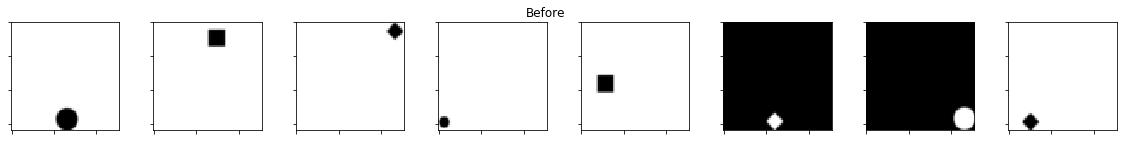

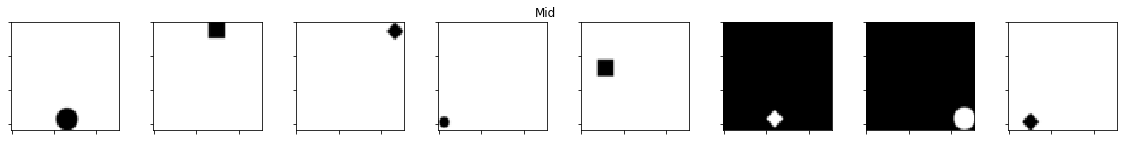

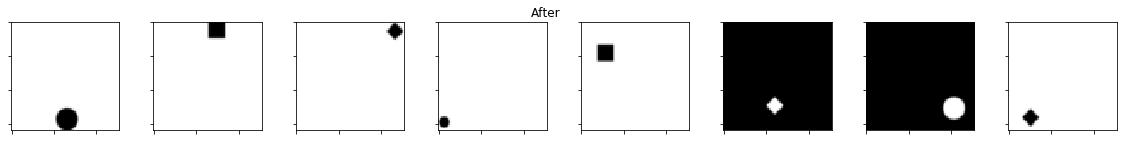

In [5]:
def show_sample_train(batch_size, gap):
    before, after, mid = sample_train(batch_size=batch_size, gap=gap)
    print("Range of Image Piece Value: [{}, {}]".format(np.min(mid), np.max(mid)))
    print("Before: {}".format(before.shape))
    print("After:  {}".format(after.shape))
    print("Mid:    {}".format(mid.shape))
    size = (20, 2)
    plot_images(before, size, "Before")
    plot_images(mid, size, "Mid")
    plot_images(after, size, "After")
    
show_sample_train(batch_size = 8, gap = 9)

## Sample of Test Data

Range of Image Piece Value: [-1.0, 1.0]
Before: (8, 64, 64)
After:  (8, 64, 64)
Mid:    (8, 64, 64)


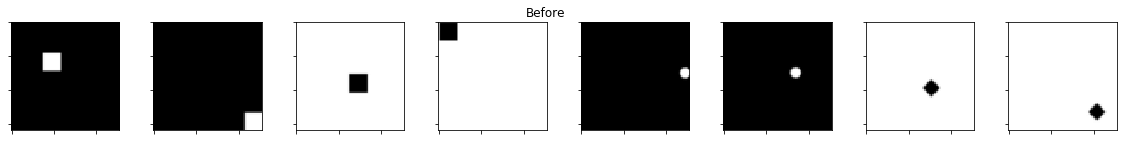

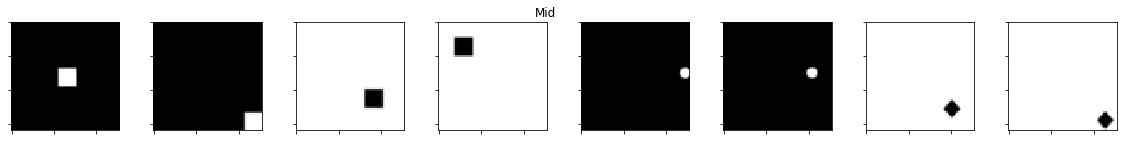

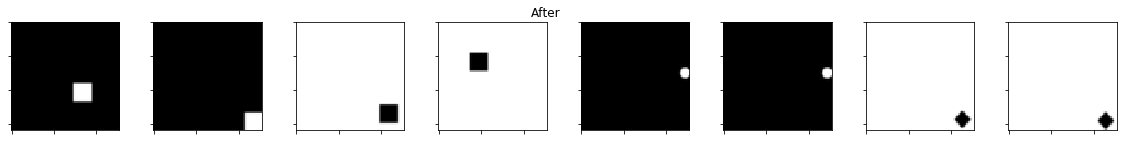

In [6]:
def show_sample_test(batch_size, gap):
    before, after, mid = sample_test(batch_size=batch_size, gap=gap)
    print("Range of Image Piece Value: [{}, {}]".format(np.min(mid), np.max(mid)))
    print("Before: {}".format(before.shape))
    print("After:  {}".format(after.shape))
    print("Mid:    {}".format(mid.shape))
    size = (20, 2)
    plot_images(before, size, "Before")
    plot_images(mid, size, "Mid")
    plot_images(after, size, "After")

show_sample_test(batch_size=8, gap = 9)

## Target

### Gap: How harsh do you want to train the model?

In [7]:
gap = 1

### Model Capacity

In [8]:
feature_channel = 256

## Param

In [34]:
batch_size = 32

learning_rate = 8e-5

beta = 0.7 # defalut 0.9 for adam
num_iteration = 8000
curr_time = time()
model_save_path = "../trained_model/box-64x64/{}/".format(curr_time)
curve_save_path = "../output/learning_curve/box-64x64-{}".format(curr_time)

## Create Directory for Model to be saved

In [35]:
try:
    os.mkdir(model_save_path)
    print("Model to be saved at {}".format(model_save_path))
except:
    assert "Cannot create save folder!"

Model to be saved at ../trained_model/box-64x64/1496688058.341177/


# Encoder

In [37]:
def encode(img, is_training=True):
    """
    Input:
        batch size of img
    Output:
        batch size of feature [batch_size, 8, 8, feature_channel]
    """
    x = tf.reshape(img, [-1, 64, 64, 1])
    x = tf.layers.conv2d(x, filters = 32, kernel_size=5, strides=2, padding='same', activation=tf.nn.relu)
    
    x = tf.layers.conv2d(x, filters = 64, kernel_size=4, strides=2, padding='same', activation=tf.nn.relu)

    x = tf.layers.conv2d(x, filters = 128, kernel_size=3, strides=1, padding='same', activation=tf.nn.relu)

    x = tf.layers.conv2d(x, filters = 128, kernel_size=2, padding='same', activation=tf.nn.relu)
    
    x = tf.layers.conv2d(x, filters = feature_channel, kernel_size=2, padding='same', activation=tf.nn.relu)
    return x

# Decoder

In [39]:
def decode(feature1, feature2, is_training=True):
    """
    Input:
        batch size of feature [batch_size, 8, 8, feature_channel]
    Output:
        batch size of img [batch_size, 32, 32, 1]
    """
    x = tf.concat([feature1, feature2], axis=3)

    x = tf.layers.conv2d_transpose(x, filters=32, kernel_size=2, strides=1, activation=tf.nn.relu, padding='same')
    x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=3, strides=1, activation=tf.nn.relu, padding='same')
    x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=2, activation=tf.nn.relu, padding='same')
    x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=5, strides=2, activation=tf.nn.relu, padding='same')
    x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=3,  strides=1, activation=tf.nn.tanh, padding='same')
    x = tf.layers.conv2d_transpose(x, filters=32, kernel_size=2,  strides=1, activation=tf.nn.tanh, padding='same')
    img = tf.layers.conv2d_transpose(x, filters=1, kernel_size=2,  strides=1, activation=tf.nn.tanh, padding='same')
    return img

## Generator

In [40]:
def generate(x1, x2,  is_training=True):
    with tf.variable_scope("generator") as scope:
        feature1, feature2 = encode(x1, is_training), encode(x2, is_training)
        img = decode(feature1, feature2, is_training)
        return img

### Loss

In [41]:
def content_loss(x, gd):
    x, gd = tf.contrib.layers.flatten(x), tf.contrib.layers.flatten(gd)
    return tf.norm(x-gd)

### Get a Batch Generation

In [42]:
def get_generattion(before, after, mid):
    dic = {batch_before: before, batch_after: after, batch_mid: mid, is_training: False}
    gen_batch = sess.run(G_batch, dic)
    return gen_batch

### Solver

In [43]:
def get_solver(learning_rate=1e-3, beta1=0.5):
    return tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)

### Report Loss = loss_computed * 255 / batch_size

In [44]:
def report_loss(name, num_run = 100, gap = 3, batch_size = batch_size):
    losses = []
    for _ in range(num_run):
        if name == "train": before, after, mid = sample_train(batch_size, gap)
        elif name == "val": before, after, mid = sample_dev(batch_size, gap)
        else:                before, after, mid = sample_test(batch_size, gap) 
        loss = sess.run(G_loss, \
                        feed_dict = {batch_before: before, batch_after: after, batch_mid: mid, is_training: False})
        losses.append(loss)
    return scale_loss(np.mean(losses) / batch_size, 2)

## Computational Graph

In [45]:
tf.reset_default_graph()
batch_mid        = tf.placeholder(tf.float32, [None, 64, 64], name = "batch_mid")
batch_before     = tf.placeholder(tf.float32, [None, 64, 64], name = "batch_before")
batch_after      = tf.placeholder(tf.float32, [None, 64, 64], name = "batch_after")
is_training      = tf.placeholder(tf.bool, (), name = "is_training")

G_batch = generate(batch_before, batch_after)

G_loss = content_loss(G_batch, batch_mid)
G_solver = get_solver(learning_rate, beta)

G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator') 

G_train_step = G_solver.minimize(G_loss, var_list=G_vars)

# add to saver
tf.add_to_collection('G_batch', G_batch)
tf.add_to_collection('loss', G_loss)

In [46]:
def train(sess, G_step, G_loss, batch_size, num_iteration, plot_every = 400, \
          show_loss_every=400, nPlot=6, num_plot = 6, save_every = 1000):
    g_losses = []
    saver = tf.train.Saver()
    for i in range(1, num_iteration+1):
        # get a sample
        gap = np.random.choice([1,3,5,7,9])
        real_before, real_after, real_mid = sample_train(batch_size, gap)
        dic = {batch_mid: real_mid, batch_before: real_before, batch_after: real_after, is_training: True}
        
        _, G_loss_curr = sess.run([G_train_step, G_loss], dic)
        G_loss_curr = scale_loss(G_loss_curr/batch_size, 2)# tweek loss to match report loss
        
        g_losses.append(G_loss_curr)
    
        if i%show_loss_every ==0:
            print("Iteration {}:  G_loss = {} | Gap = {}".format(i, G_loss_curr, gap))
            
        if i%plot_every == 0:
            real_before, real_after, real_mid = sample_train(num_plot, gap)
            gen_batch_test = sess.run(G_batch, feed_dict=\
                                      {batch_before: real_before, batch_after: real_after, is_training: False})
            plot_batch_images(gen_batch_test[:nPlot], (16, 2) , "Iteration: {} | gap = {}".format(i, gap))
        if i%save_every == 0:
            saver.save(sess, model_save_path, global_step = i)   
    save_learning_curve(iterations = list(range(1, num_iteration+1)), loss = g_losses, save_path = curve_save_path)
    return g_losses

# Train !

In [47]:
sess = get_session()
sess.run(tf.global_variables_initializer())
g_loss = train(sess, G_train_step, G_loss, batch_size, num_iteration, \
               plot_every = 400, show_loss_every = 400, num_plot=6, save_every = 4000)

ResourceExhaustedError: OOM when allocating tensor with shape[32,128,17,17]
	 [[Node: generator/conv2d_10/convolution = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](generator/conv2d_9/Relu, generator/conv2d_9/kernel/read)]]
	 [[Node: norm/Squeeze/_7 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_653_norm/Squeeze", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'generator/conv2d_10/convolution', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/traitlets/config/application.py", line 592, in launch_instance
    app.start()
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 405, in start
    ioloop.IOLoop.instance().start()
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/tornado/ioloop.py", line 883, in start
    handler_func(fd_obj, events)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 260, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 212, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 370, in execute_request
    user_expressions, allow_stdin)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 175, in do_execute
    shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2902, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 3006, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 3066, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-45-15f759afe028>", line 7, in <module>
    G_batch = generate(batch_before, batch_after)
  File "<ipython-input-40-d8f90fa16489>", line 3, in generate
    feature1, feature2 = encode(x1, is_training), encode(x2, is_training)
  File "<ipython-input-37-e6cea4f606ff>", line 17, in encode
    x = tf.layers.conv2d(x, filters = feature_channel, kernel_size=2, padding='same', activation=tf.nn.relu)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/tensorflow/python/layers/convolutional.py", line 509, in conv2d
    return layer.apply(inputs)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/tensorflow/python/layers/base.py", line 303, in apply
    return self.__call__(inputs, **kwargs)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/tensorflow/python/layers/base.py", line 273, in __call__
    outputs = self.call(inputs, **kwargs)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/tensorflow/python/layers/convolutional.py", line 156, in call
    data_format=utils.convert_data_format(self.data_format, self.rank + 2))
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/tensorflow/python/ops/nn_ops.py", line 639, in convolution
    op=op)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/tensorflow/python/ops/nn_ops.py", line 308, in with_space_to_batch
    return op(input, num_spatial_dims, padding)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/tensorflow/python/ops/nn_ops.py", line 631, in op
    name=name)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/tensorflow/python/ops/nn_ops.py", line 129, in _non_atrous_convolution
    name=name)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 396, in conv2d
    data_format=data_format, name=name)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2327, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1226, in __init__
    self._traceback = _extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[32,128,17,17]
	 [[Node: generator/conv2d_10/convolution = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](generator/conv2d_9/Relu, generator/conv2d_9/kernel/read)]]
	 [[Node: norm/Squeeze/_7 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_653_norm/Squeeze", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


## Plot Learning Curve

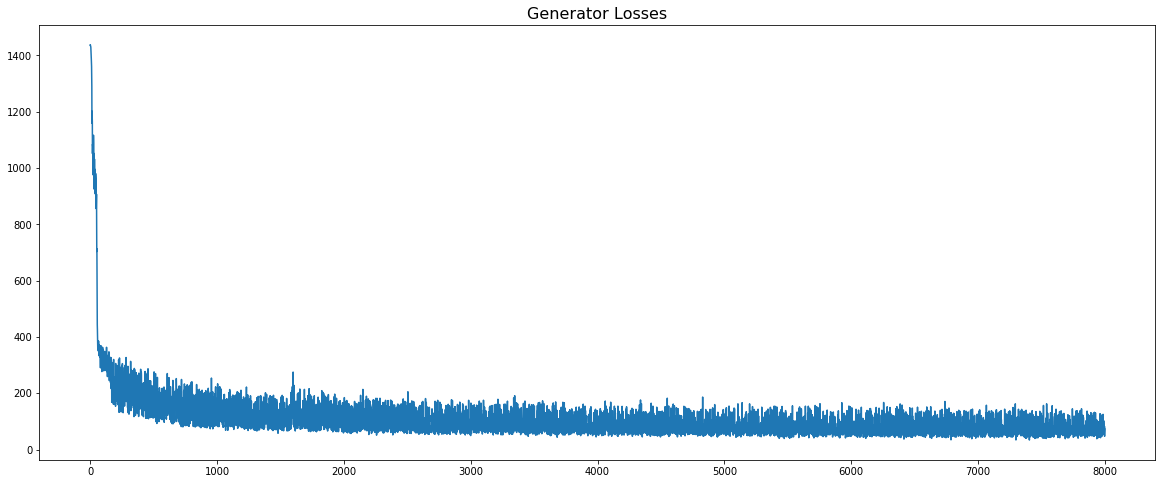

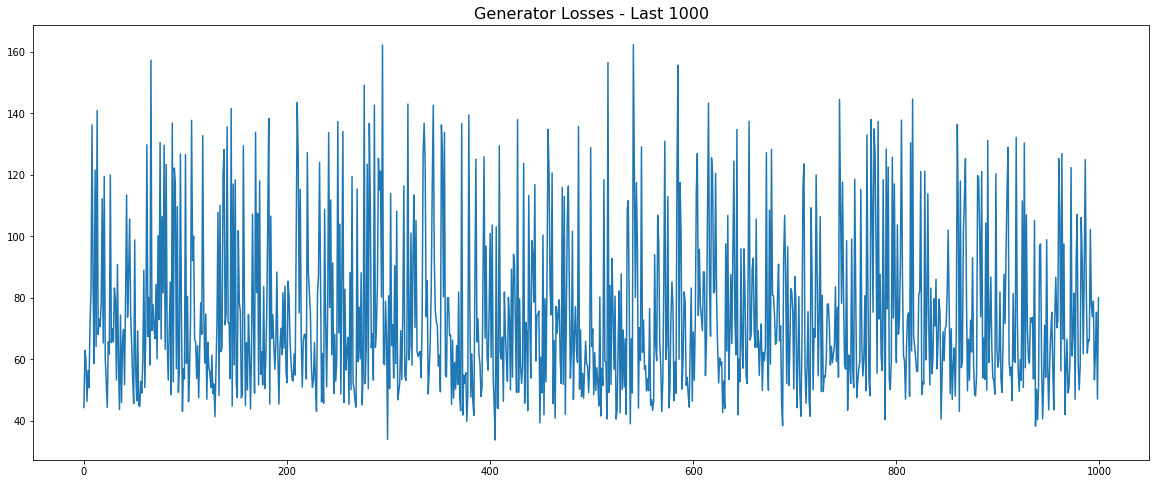

In [60]:
figsize = (20, 8)

plt.figure(figsize=figsize)
plt.plot(g_loss)
plt.title("Generator Losses", fontsize=16)
plt.show()

plt.figure(figsize=figsize)
plt.plot(g_loss[-1000:])
plt.title("Generator Losses - Last 1000", fontsize=16)
plt.show()

# Evaluate !

In [61]:
def show_generations(name, num = 6, gap = 3):
    if name == "train":  before, after, mid = sample_train(num, gap)
    else:                before, after, mid = sample_test(num, gap) 
    
    gen_batch = get_generattion(before, after, mid)
    size = (20, 2)
    plot_images(before, size, "Before")
    plot_images(after, size, "After")
    plot_images(mid, size, "Mid - Real")
    plot_images(gen_batch, size, "Mid - Generated")

## - Evaluate on Training Data

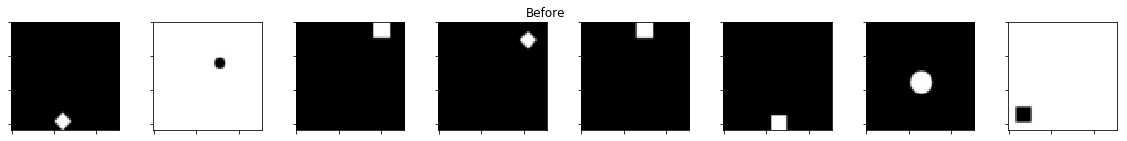

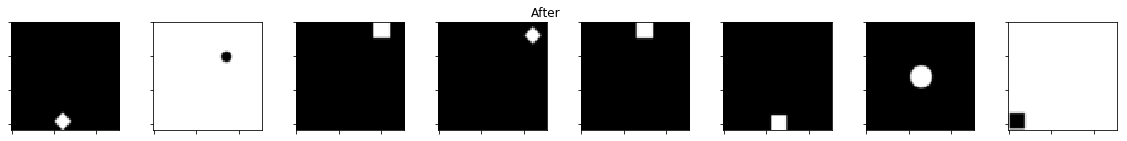

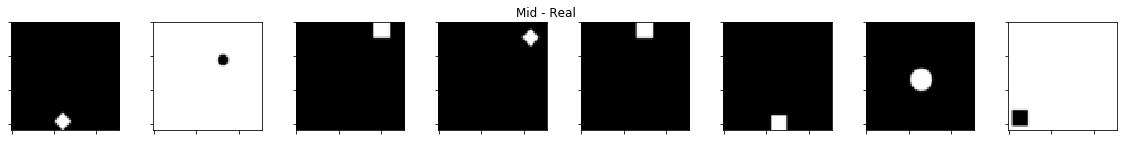

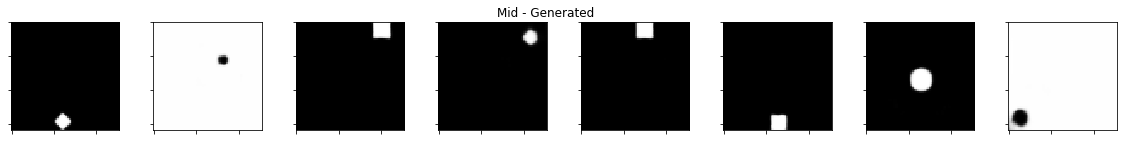

Training Loss = 53.93665798008442


In [62]:
def eval_train(num_show = 8, gap = 3):
    show_generations("train", num_show, gap)
    loss = report_loss("train", 100, gap, batch_size)
    print("Training Loss = {}".format(loss))
    return loss

train_loss = eval_train(num_show = 8, gap = gap)

## - Evaluate on Test Data

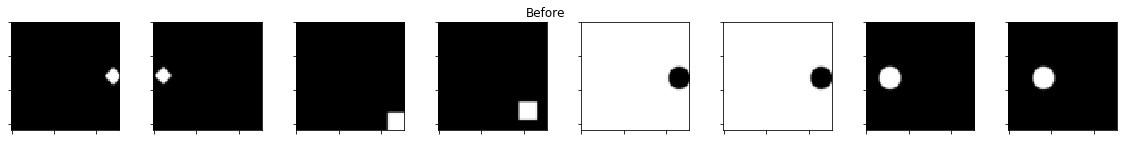

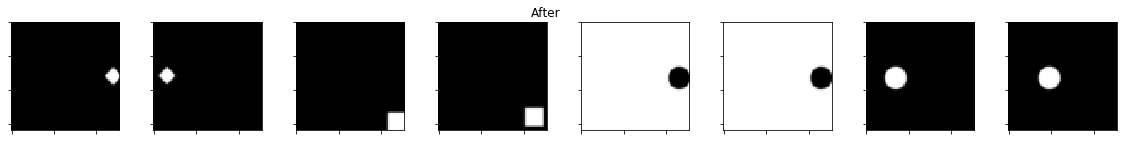

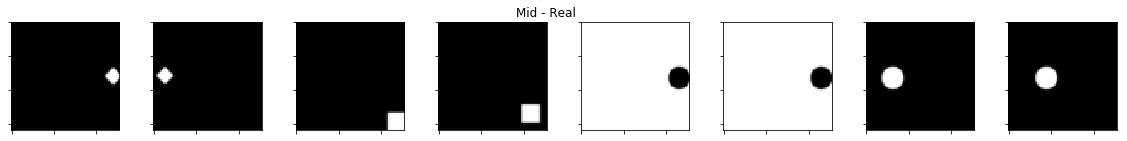

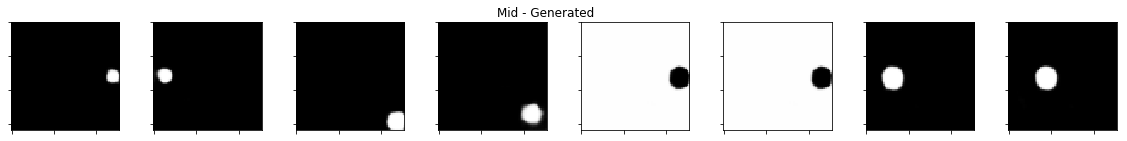

Test Loss = 178.646881878376


In [63]:
def eval_test(num_show = 6, gap = 3, num_test = 100, batch_size = batch_size):
    show_generations("test", num_show, gap)
    loss = report_loss("test", num_test, gap, batch_size)
    print("Test Loss = {}".format(loss))
    return loss

test_loss = eval_test(num_show = 8, gap=1, batch_size = 8)

## How much overfitting?

In [64]:
print("(Test Loss - Train Loss)/Train Loss = {}".format((test_loss-train_loss)/train_loss))

(Test Loss - Train Loss)/Train Loss = 2.3121607561287836
